**Question 1**
* Gabriel Cutshaw
* Dante Goldner
* Mattan Tseng
* Hossen Zaremehrjerdi


In [1]:
import numpy as np
import h5py
from einops import rearrange
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
import time
import datetime
from torchmetrics.classification import BinaryAccuracy

print(torch.__version__)


2.0.0+cu117


In [4]:
data_path = "./combustion_img_13.mat"
arrays = {}


data = h5py.File(data_path)

for k, v in data.items():
    arrays[k] = np.array(v)


test_set_x = arrays["test_set_x"]
test_set_y = arrays["test_set_y"]
train_set_x = arrays["train_set_x"]
train_set_y = arrays["train_set_y"]
valid_set_x = arrays["valid_set_x"]
valid_set_y = arrays["valid_set_y"]

In [5]:
print("The shape of test x: ", test_set_x.shape)
print("The shape of test y: ", test_set_y.shape)
print("The shape of train x: ", train_set_x.shape)
print("The shape of train y: ", train_set_y.shape)
print("The shape of validation x: ", valid_set_x.shape)
print("The shape of validation y: ", valid_set_y.shape)

The shape of test x:  (25000, 18000)
The shape of test y:  (18000, 1)
The shape of train x:  (25000, 54000)
The shape of train y:  (54000, 1)
The shape of validation x:  (25000, 9000)
The shape of validation y:  (9000, 1)


shape of test array:  (18000, 100, 250)
shape of train array:  (54000, 100, 250)
shape of validation array:  (9000, 100, 250)
This image is labeled:  [1]  (stable)


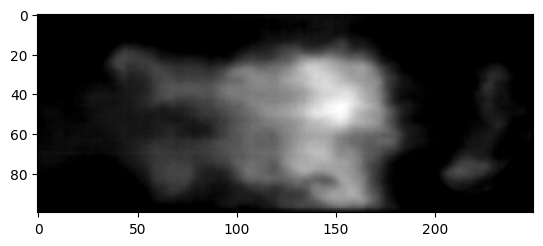

In [6]:
# image dimensions per the assignment:
image_shape = (250, 100)

# test set is not used at all in training. 
test_images = rearrange(test_set_x, "(x y) i -> i y x", x = image_shape[0], y = image_shape[1])
# train set is used to actually train the model
train_images = rearrange(train_set_x, "(x y) i -> i y x", x = image_shape[0], y = image_shape[1])
# train_labels = rearrange(train_set_y, "x y -> y x")
# validation set is used to avoid overfitting 
validation_images = rearrange(valid_set_x, "(x y) i -> i y x", x = image_shape[0], y = image_shape[1])
print("shape of test array: ", test_images.shape)
print("shape of train array: ", train_images.shape)
print("shape of validation array: ", validation_images.shape)


plt.imshow(train_images[0, :, :], cmap="gist_gray")
print("This image is labeled: ", test_set_y[0], " (stable)")

# plt.imshow(np.zeros((10, 10)), cmap="Greys")


This image is labeled:  [0]  (unstable)


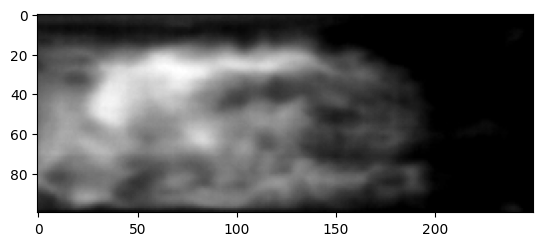

In [7]:
plt.imshow(test_images[2000, :, :], cmap='gist_gray')
print("This image is labeled: ", test_set_y[2000], " (unstable)")

Text(0, 0.5, 'instances')

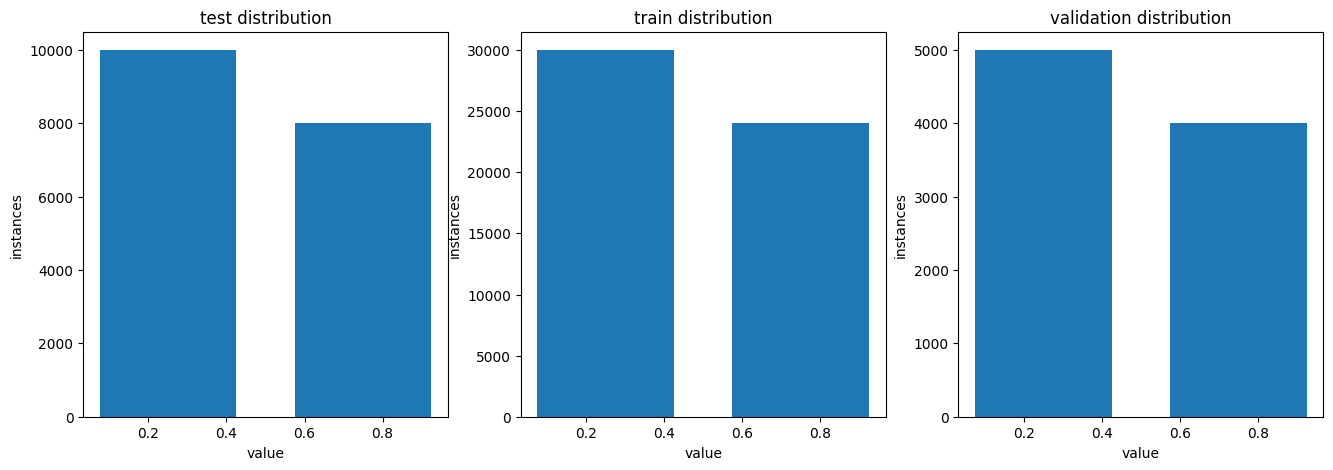

In [8]:
# plot out the distributions of stable/unstable images for each subset. 
fig, ax = plt.subplots(1, 3, figsize = (16, 5))
ax[0].set_title("test distribution")
ax[0].hist(test_set_y, bins = 2, rwidth = 0.7)
ax[0].set_xlabel("value")
ax[0].set_ylabel("instances")

ax[1].set_title("train distribution")
ax[1].hist(train_set_y, bins = 2, rwidth = 0.7)
ax[1].set_xlabel("value")
ax[1].set_ylabel("instances")


ax[2].set_title("validation distribution")
ax[2].hist(valid_set_y, bins = 2, rwidth = 0.7)
ax[2].set_xlabel("value")
ax[2].set_ylabel("instances")


In [9]:
# Define the CNN architecture

# These links were used for reference 
# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
# https://www.analyticsvidhya.com/blog/2019/10/building-image-classification-models-cnn-pytorch/
# https://towardsdatascience.com/binary-image-classification-in-pytorch-5adf64f8c781

# hyperparameters:
batch_size = 4
epochs = 1
learning_rate = 0.001
stride = 1
kernel = 3
dropout_probability = 0.01

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=kernel, stride = stride)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=kernel, stride=stride)
        self.pool = nn.MaxPool2d(2,2)
        # self.fc1 = nn.Linear(800, 64)
        self.fc1 = nn.Linear(89792, 1000)
        self.dropout = nn.Dropout(p = dropout_probability)
        self.fc2 = nn.Linear(1000, 1)


    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))


        # flatten all dimensions except batch
        x = torch.flatten(x, 1)
        # activation function
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x



input_height = train_images[0].shape[0]
input_width = train_images[0].shape[1]



classes = ("stable", "unstable")
number_channels = 1 # this is a grayscale image
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# to increase the speed of the training, make sure that the GPU is being used. 
print("Is GPU available: ", torch.cuda.is_available())
print("Number of epochs: ", epochs)
print("Batch size: ", batch_size)
print("Stride size: ", stride)
print("Classes: ", classes)
print("input height: ", input_height)
print("input width: ", input_width)

# now prepare the training and validation sets
# normalize the image from 0 to 1 instead of 0 to 255
train_images_torch = torch.div(torch.from_numpy(train_images).float(), 255)
# convert labels array to a torch tensor
train_labels_torch = torch.from_numpy(train_set_y).float()
# create a dataset from teh tensor
train_dataset = torch.utils.data.TensorDataset(train_images_torch, train_labels_torch)
# wrap the dataset into a dataloader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=6)



validation_images_torch = torch.div(torch.from_numpy(validation_images).float(), 255)
validation_labels_torch = torch.from_numpy(valid_set_y).float()
validation_dataset = torch.utils.data.TensorDataset(validation_images_torch, validation_labels_torch)
validation_loader =  torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, num_workers=6)

Is GPU available:  True
Number of epochs:  1
Batch size:  4
Stride size:  1
Classes:  ('stable', 'unstable')
input height:  100
input width:  250


In [10]:
# instantiate the model
cnn = CNN()
# make sure the model is running on the GPU if its available
cnn.to(device)
print(cnn)
# criterion = nn.CrossEntropyLoss()
criterion = nn.modules.loss.BCEWithLogitsLoss()
optimizer = optim.SGD(cnn.parameters(), lr=learning_rate, momentum=0.9)

# start a clock 
start_time = time.time()

# create empty arrays to hold the loss results
training_losses = []
validation_losses = []
for epoch in range(epochs):
    # set the model to training mode
    cnn.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        # ugh. This is gross. I should have done this step at the beginning for all of the datasets. 
        inputs = rearrange(inputs, "(c b) h w -> b c h w", c = 1)
        # zero the parameter gradients
        optimizer.zero_grad()

        # run the training data through the model
        outputs = cnn(inputs)

        #calculate the loss of the model
        loss = criterion(outputs, labels)

        running_loss += loss.item()
        
        if i % 500 == 499:    # record loss and test validation set
            validation_running_loss = 0.0
            for v, vdata in enumerate(validation_loader):
                cnn.eval() # change the model to evaluation mode
                vinputs, vlabels = vdata[0].to(device), vdata[1].to(device)
                vinputs = rearrange(vinputs, "(c b) h w -> b c h w", c = 1)
                voutputs = cnn(vinputs)

                vloss = criterion(voutputs,vlabels)
                validation_running_loss += vloss.item()
            
            print("epoch: ", epoch+1, "batch: ", i+1, "Training loss: ", running_loss, "\tValidation loss: ", validation_running_loss)
            validation_losses.append(validation_running_loss)
            training_losses.append(running_loss)
            running_loss = 0.0
        

        # once the validation has been completed, update the model
        loss.backward()
        optimizer.step()
        # set model back to training mode
        cnn.train()



end_time = time.time()
train_time = end_time - start_time
print("Elapsed Training Time: ", datetime.timedelta(seconds = train_time))
print('Finished Training')

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=89792, out_features=1000, bias=True)
  (dropout): Dropout(p=0.01, inplace=False)
  (fc2): Linear(in_features=1000, out_features=1, bias=True)
)
epoch:  1 batch:  500 Training loss:  133.34835119254421 	Validation loss:  305.11254703493796
epoch:  1 batch:  1000 Training loss:  27.252243675000727 	Validation loss:  66.93654559042312
epoch:  1 batch:  1500 Training loss:  9.656204615572705 	Validation loss:  46.995031668883136
epoch:  1 batch:  2000 Training loss:  9.043657496612994 	Validation loss:  17.674074972431058
epoch:  1 batch:  2500 Training loss:  5.263833903456522 	Validation loss:  47.252706450770376
epoch:  1 batch:  3000 Training loss:  15.119703109931642 	Validation loss:  8.642813689357595
epoch:  1 batch:  3500 Training loss:  2.481729

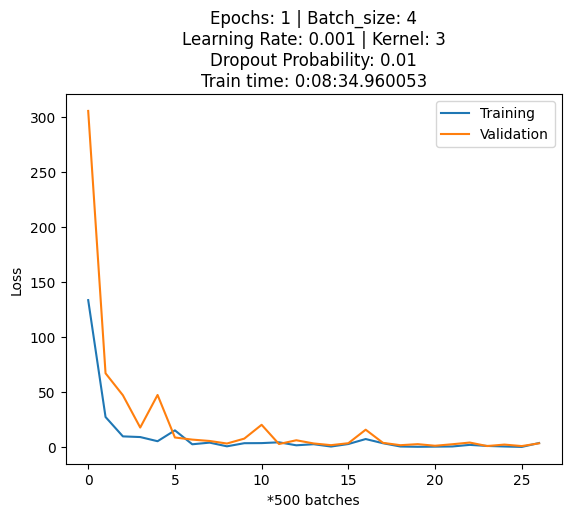

In [11]:
loss_title = "Epochs: " + str(epochs) + " | Batch_size: " + str(batch_size) + "\nLearning Rate: " + str(learning_rate) + " | Kernel: " + str(kernel) + "\nDropout Probability: " + str(dropout_probability) + "\nTrain time: " + str(datetime.timedelta(seconds = train_time))
plt.title(loss_title)
plt.xlabel("*500 batches")
plt.ylabel("Loss")

# plt.yscale("log")
plt.plot(training_losses, label= "Training")
plt.plot(validation_losses, label = "Validation")
plt.legend()


figname = "e"+str(epochs)+"bs"+str(batch_size)+"lr"+str(learning_rate)+"k"+str(kernel)+"dp"+str(dropout_probability)+".png"
#print(figname)
#plt.savefig(figname)

In [12]:
# now that the training has been completed, run through the test set.
test_images_torch = torch.div(torch.from_numpy(test_images).float(), 255)
test_labels_torch = torch.from_numpy(test_set_y).float()
test_dataset = torch.utils.data.TensorDataset(test_images_torch, test_labels_torch)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=6)

test_losses = []

test_accuracy = []

binaryacc = BinaryAccuracy()

for i, test_data in enumerate(test_loader):
    # set model to evaluation mode
    cnn.eval()
    test_inputs, test_labels = test_data[0].to(device), test_data[1].to(device)
    test_inputs = rearrange(test_inputs, "(c b) h w -> b c h w", c = 1)
    test_outputs = cnn(test_inputs)
    test_loss = criterion(test_outputs, test_labels)
    test_losses.append(test_loss.item())

    # test_accuracy.append(binaryacc(test_outputs,test_labels))

test_losses = np.asarray(test_losses)

print("Loss mean of test: ", test_losses.mean())
print("Max loss of test: ", test_losses.max())
print("Min loss of test: ", test_losses.min())


Loss mean of test:  0.0012400142726416178
Max loss of test:  0.650763213634491
Min loss of test:  0.0


Prediction: Stable


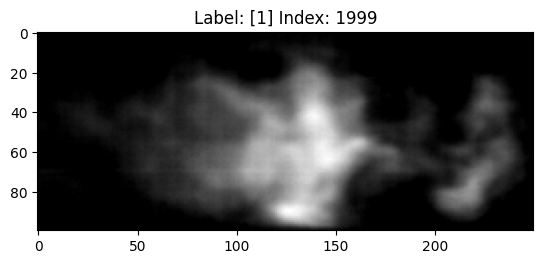

In [13]:
# Let's create a function to take 1 random image in and predict whether it is stable or sunstable

index = np.random.randint(18000)

image = test_images[index,:,:]
label = test_set_y[index]

image_title = "Label: " + str(label) + " Index: " + str(index)

plt.title(image_title)
plt.imshow(image, cmap="gist_gray")

sample = torch.div(torch.from_numpy(image).float(), 255)
sample = rearrange(sample, "(b c h) w -> b c h w", c = 1, b = 1)
sample = sample.to(device)

cnn.eval() # set model to evaluation mode
if torch.sigmoid(cnn(sample)) < 0.5:
    print("Prediction: Unstable")
else:
    print("Prediction: Stable")


